In [ ]:
import sys
import os
sys.path.append(os.path.abspath('../src/')) # Add the src/ folder to the system path
import utils
import numpy as np
import stfp_func as bf
import torch
from tqdm import tqdm

Input dimensions: (384, 384)
Output dimensions: (384, 384)


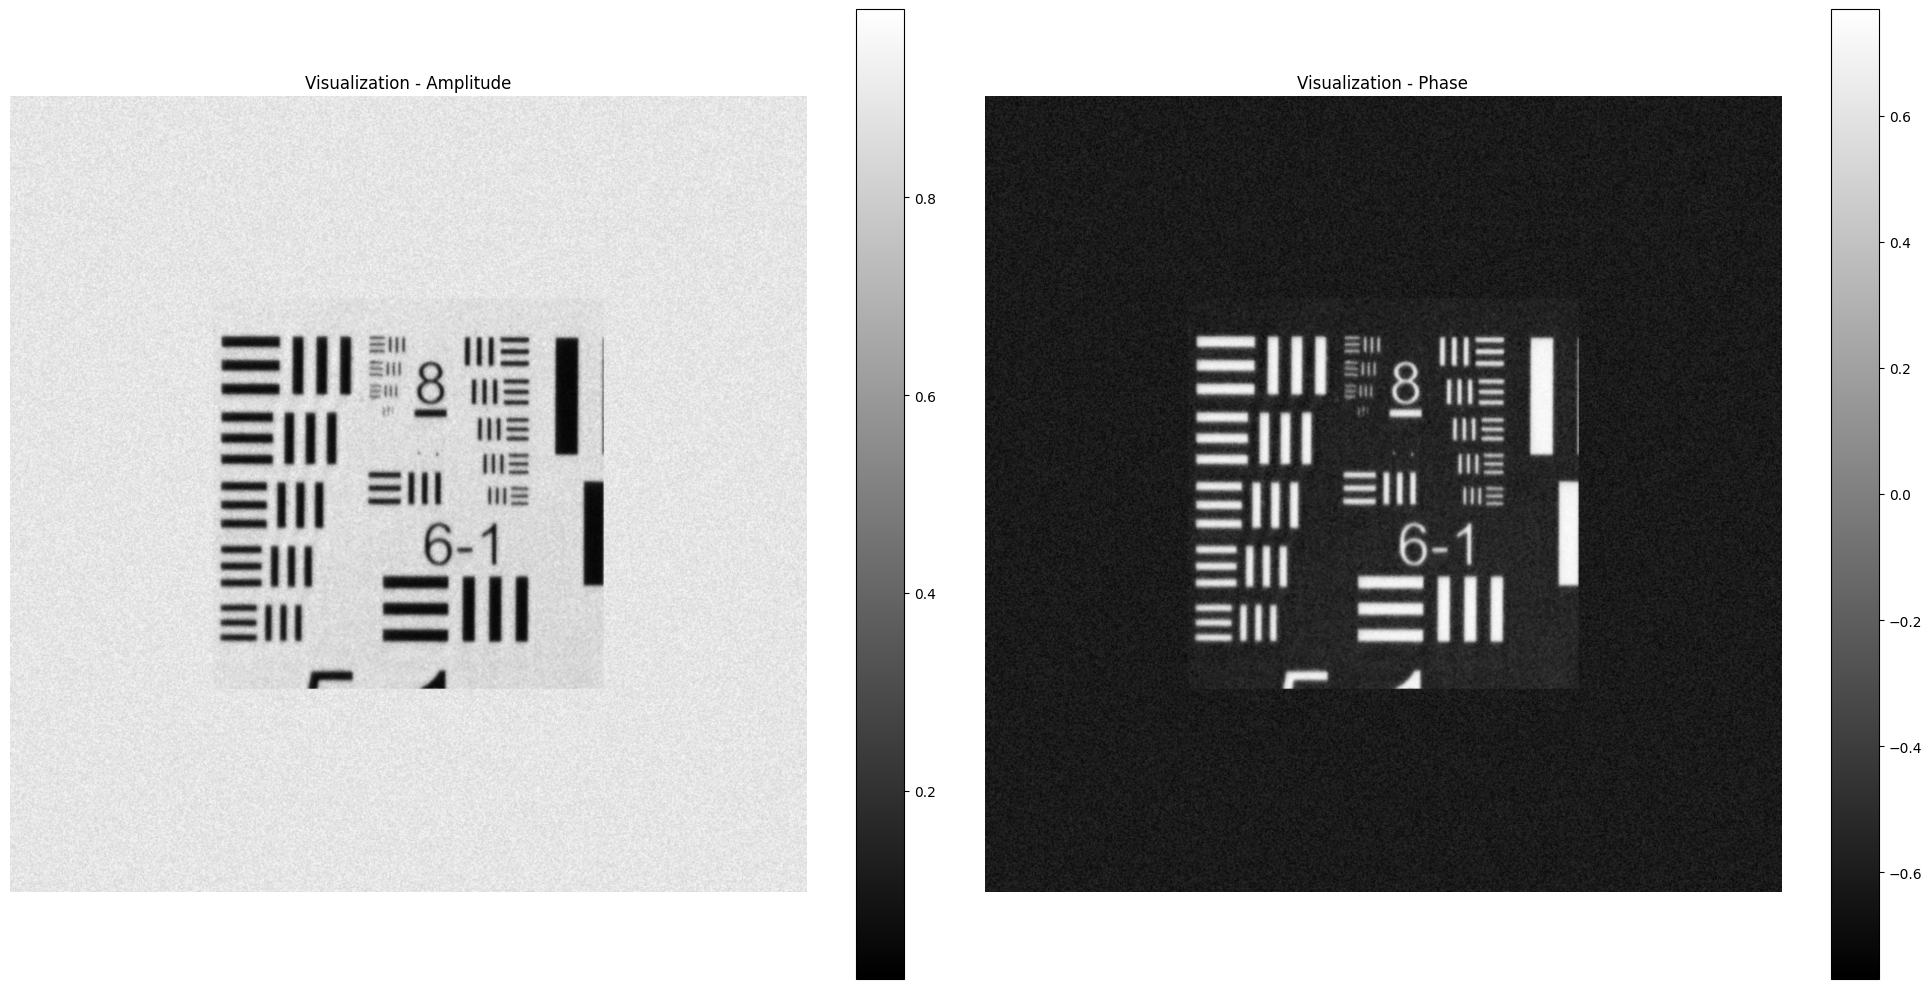

In [ ]:
usaf = bf.read_mat('../data/', 'usaf_target')
print('[Warning replace with your own data]')
target_size = 784 
pad_noise = (120 + 20 * torch.rand(target_size, target_size, dtype=usaf.dtype, device=usaf.device))
pad_noise[200:200+384, 200:200+384] = usaf # Insert the original tensor into the center
padded_usaf = pad_noise

new_size1 = (1500, 1500)  
am = bf.rescale_tensor(bf.add_gaussian_noise(bf.norm_rescale(torch.nn.functional.interpolate(padded_usaf.unsqueeze(0).unsqueeze(0), size=new_size1, mode='bilinear').squeeze()), mean=0.0, std=0.005), 0.01, 0.99)
ph = -(am-0.5)*torch.pi/2
Obj_full_view = am * torch.exp(1j*ph)
bf.visualize_tensor(Obj_full_view)

In [3]:
## Define parameters
T = 10  # Number of timestamps 
T_all = T + 4 
H, W = Obj_full_view.shape[-2:] 
padding_size = 100  # To prevent edge artifacts
# Define time-varying swirl strength (example: linearly increasing)
half_linspace = torch.linspace(-0.5, 0.5, 40)
half_linspace_ = torch.linspace(0.5, -0.5, 40)
swirl_strengths = torch.cat([half_linspace, half_linspace_, half_linspace, torch.zeros(4)]) 
swirled_obj_3d = torch.zeros((T_all, H, W), dtype=torch.complex64, device=Obj_full_view.device)
# Generate 3D tensor over time
for t in range(T_all):
    swirl_strength = swirl_strengths[t].item()
    swirled_obj_3d[t] = bf.swirl2d(Obj_full_view, swirl_strength, padding_size)
crop_row1, crop_row2 = 402, 1002
crop_col1, crop_col2 = 450, 1050
new_am_seq = torch.clamp(bf.norm_rescale_3Dslice(bf.histogram_matching(torch.clamp(bf.norm_rescale_3Dslice(swirled_obj_3d[:,crop_row1:crop_row2,crop_col1:crop_col2].abs()), min= 1e-2, max= 0.98), T_all-1)), min= 1e-2)
new_ph_seq = -(new_am_seq-0.5)*torch.pi/2
Obj_full_view_seq = new_am_seq * torch.exp(1j*new_ph_seq)
del swirled_obj_3d, new_am_seq, new_ph_seq

Rreplace with your designed patterns


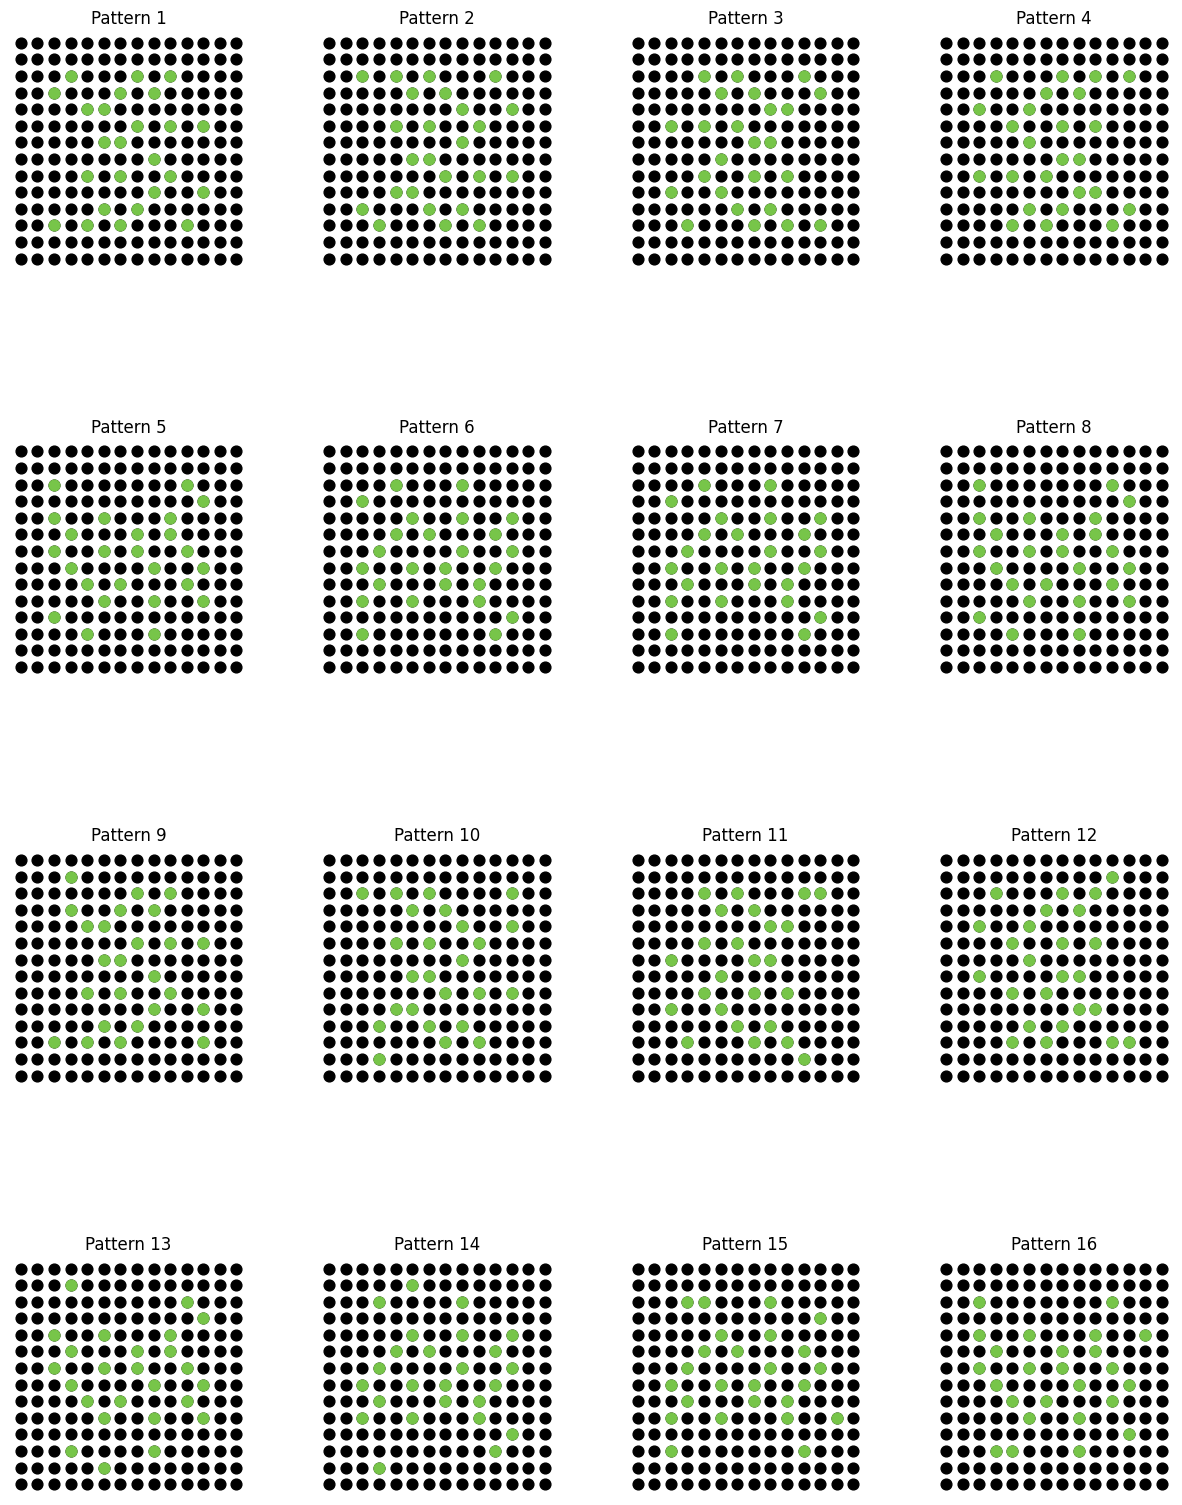

In [ ]:
## load the pattern
pattern = bf.read_cell_mat('../data/', 'pattern5x16p_v2')
print('[Warning] Rreplace with your designed patterns')
single_pattern = []
for pattern_tmp in pattern: 
    single_pattern.append(pattern_tmp[0, :]) 
    single_pattern.append(pattern_tmp[1, :]) 
bf.pattern_show(single_pattern)
del pattern_tmp

In [5]:
## parameter setting
FP = bf.FP_parameter(
    wavelength=0.53e-6,
    pix=3e-6,  # Pixel size of the CCD
    mag=5,
    mag_image=3,
    NA=0.14,
    arraysize=14,
    LEDgap=5e-3,
    LEDheight=80e-3,
    device="cuda"  # Use GPU if available
)

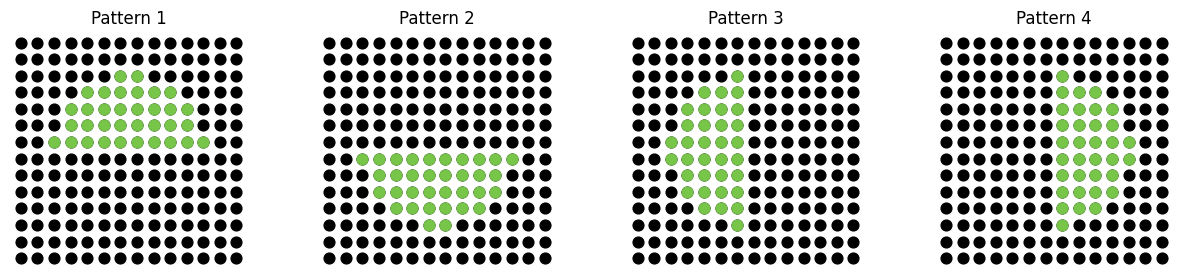

In [6]:
top_idx, bottom_idx = bf.pattern_dpc(2.0*FP.NA, FP, theta=0.0)
left_idx, right_idx = bf.pattern_dpc(2.0*FP.NA, FP, theta=90.0)
arraysize = FP.arraysize  
num_leds = int(arraysize * arraysize)
dpc_single_pattern = []
for idx_group in [top_idx, bottom_idx, left_idx, right_idx]:
    mask = torch.zeros(num_leds, dtype=torch.float64)
    mask[idx_group.view(-1).long()] = 1.0  # Set 1 at active LED positions
    dpc_single_pattern.append(mask) 
bf.pattern_show(dpc_single_pattern)    


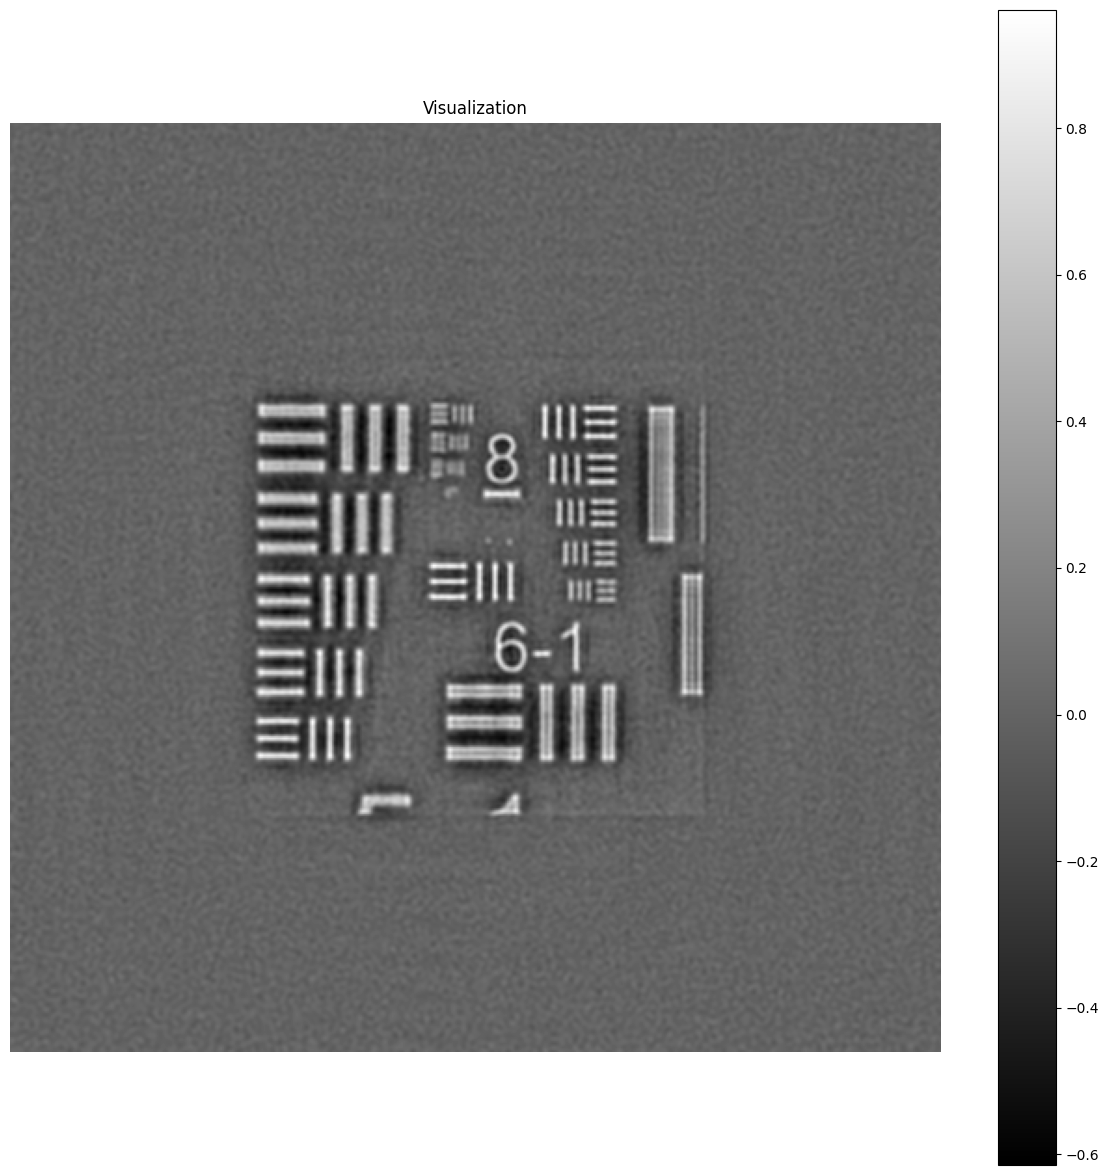

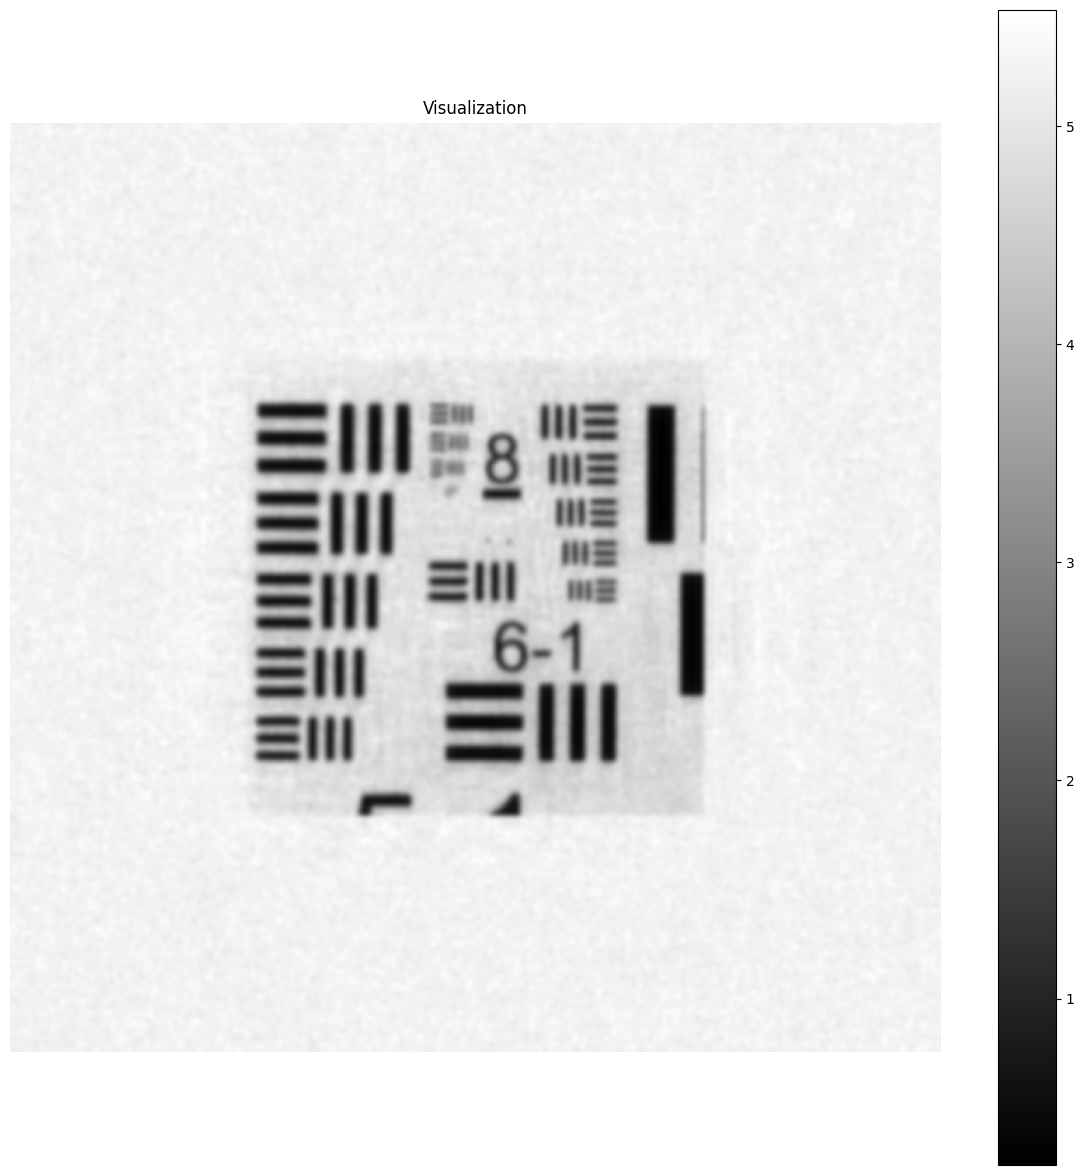

In [7]:
## phase initialization in quasi static condition
LR_data_ = bf.FP_forward(FP,Obj_full_view.squeeze(), device0=None) 
dpc_data = torch.zeros(int(len(dpc_single_pattern)), int(Obj_full_view.shape[0]/FP.mag_image), int(Obj_full_view.shape[1]/FP.mag_image), dtype=torch.float)
for i in range(len(dpc_single_pattern)):
    selected_index = torch.nonzero(dpc_single_pattern[i] == 1).squeeze(1)
    dpc_data[i, :, :] = torch.sum(LR_data_[selected_index, :, :], dim=0)
dpc_data[[0, 1], :, :] = dpc_data[[1, 0], :, :] 
mask_half_len = 20
reg2 = 0.15
phase_ref_full_view = bf.phase_gen_multi_pat(dpc_data,dpc_single_pattern,FP,mask_half_len,reg2)
phase_ref_full_view = phase_ref_full_view*1
bf.visualize_tensor(phase_ref_full_view, cmap="gray")
del LR_data_, selected_index

## amplitude initialization by near bright field (top+bottom)
LR_data_ = bf.FP_forward(FP,Obj_full_view.squeeze(), device0=None) 
dpc_data = torch.zeros(int(len(dpc_single_pattern)), int(Obj_full_view.shape[0]/FP.mag_image), int(Obj_full_view.shape[1]/FP.mag_image), dtype=torch.float)
for i in range(len(dpc_single_pattern)):
    selected_index = torch.nonzero(dpc_single_pattern[i] == 1).squeeze(1)
    dpc_data[i, :, :] = torch.sum(LR_data_[selected_index, :, :], dim=0)
am_ref_full_view = torch.pow(torch.sqrt(1/4*torch.sum(dpc_data[:4], dim = 0)),1.8)
bf.visualize_tensor(am_ref_full_view, vmin=None, vmax=None, cmap="gray")

In [8]:
## forward multiplexed imaging
raw_data_ = torch.zeros(int(T), int(Obj_full_view_seq.shape[1]/FP.mag_image), int(Obj_full_view_seq.shape[2]/FP.mag_image), dtype=torch.float)
n_p = len(pattern) 
frame_num = len(single_pattern) // len(pattern) 
start_index = 0 
num_time_slot = int(T/2)
for i_ref in range(num_time_slot):
    start_ref = start_index + i_ref* frame_num  
    end_ref = start_ref + frame_num - 1
    pattern_th = int(torch.ceil(torch.remainder(torch.tensor(start_ref + 1, dtype=torch.float32), 
                                            torch.tensor(n_p * frame_num, dtype=torch.float32)) / frame_num)) -1 
    pattern_mat_tmp = pattern[pattern_th]
    FP.led_pattern_seq = torch.nonzero(pattern_mat_tmp[0, :] != 0).squeeze()
    LR_data = bf.FP_forward(FP,Obj_full_view_seq[start_ref].squeeze(), device0=None) 
    raw_data_[2*i_ref, :, :] = torch.sum(LR_data[FP.led_pattern_seq, :, :], dim=0)
    FP.led_pattern_seq = torch.nonzero(pattern_mat_tmp[1, :] != 0).squeeze()
    LR_data = bf.FP_forward(FP,Obj_full_view_seq[end_ref].squeeze(), device0=None) 
    raw_data_[2*i_ref+1, :, :] = torch.sum(LR_data[FP.led_pattern_seq, :, :], dim=0)
del LR_data

In [9]:
## preprocessing of the raw data
raw_data__ = bf.temporal_gaussian_smooth_gpu(raw_data_, sigma_time=1.0, kernel_size=5, index_frame=2)
[ss0,ss1,ss2] = raw_data_.size()

In [10]:
## generate reference target over time (initial guess) 
obj_ref_3d = torch.zeros((T, raw_data_.shape[1], raw_data_.shape[2]), dtype=torch.complex64)
am_ref_3d = torch.zeros((T, raw_data_.shape[1], raw_data_.shape[2]))
phase_ref_3d = torch.zeros((T, raw_data_.shape[1], raw_data_.shape[2]))
am_ref =  am_ref_full_view[int(crop_row1/FP.mag_image):int(crop_row2/FP.mag_image),int(crop_col1/FP.mag_image):int(crop_col2/FP.mag_image)]
phase_ref = phase_ref_full_view[int(crop_row1/FP.mag_image):int(crop_row2/FP.mag_image),int(crop_col1/FP.mag_image):int(crop_col2/FP.mag_image)]

am_ref_full_view_up_sampled = torch.clamp(bf.norm_rescale(torch.nn.functional.interpolate(am_ref_full_view.unsqueeze(0).unsqueeze(0), size=(int(FP.mag_image*am_ref_full_view.shape[0]),int(FP.mag_image*am_ref_full_view.shape[1])), mode='bilinear').squeeze()),0.01,0.99).cpu()
phase_ref_full_view_up_sampled = bf.rescale_tensor(torch.nn.functional.interpolate(phase_ref_full_view.unsqueeze(0).unsqueeze(0), size=(int(FP.mag_image*phase_ref_full_view.shape[0]),int(FP.mag_image*phase_ref_full_view.shape[1])), mode='bilinear').squeeze(), phase_ref_full_view.min(), phase_ref_full_view.max())
obj_ref_3d_full_view = torch.zeros((T, phase_ref_full_view_up_sampled.shape[0], phase_ref_full_view_up_sampled.shape[1]), dtype=torch.complex64)
for t in range(T):
    swirl_strength = swirl_strengths[t].item()
    obj_ref_3d_t_upsample= bf.swirl2d((am_ref_full_view_up_sampled * torch.exp(1j*phase_ref_full_view_up_sampled.cpu())).cpu(), swirl_strength, 100).squeeze()
    am_ref_3d[t] = torch.nn.functional.interpolate(obj_ref_3d_t_upsample.abs().unsqueeze(0).unsqueeze(0), size=(am_ref_full_view.shape[0],am_ref_full_view.shape[1]), mode='bilinear').squeeze()[int(crop_row1/FP.mag_image):int(crop_row2/FP.mag_image),int(crop_col1/FP.mag_image):int(crop_col2/FP.mag_image)]
    phase_ref_3d[t] = torch.nn.functional.interpolate(obj_ref_3d_t_upsample.angle().unsqueeze(0).unsqueeze(0), size=(am_ref_full_view.shape[0],am_ref_full_view.shape[1]), mode='bilinear').squeeze()[int(crop_row1/FP.mag_image):int(crop_row2/FP.mag_image),int(crop_col1/FP.mag_image):int(crop_col2/FP.mag_image)]

In [11]:
## generate abs&phase priors based on raw data and reference target over time
n_p = len(pattern)
frame_num = len(single_pattern) // len(pattern) 
start_index = 0 
num_time_slot = int(ss0/2)
frame_set_ = raw_data_[start_index:]
huber_l1 = utils.HuberL1Params(warps=4, lamda=1e-3, theta=0.2, epsilon=0.1, 
                               max_iteration=4, nscales=4, sigma=0.6, zfactor=0.6, gscale=255)
am_prior = torch.zeros(num_time_slot*2, raw_data_.shape[1], raw_data_.shape[2])
phase_prior = torch.zeros(num_time_slot*2, raw_data_.shape[1], raw_data_.shape[2])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for i in tqdm(range(num_time_slot*2), desc = "prior calculation"):
    ii = start_index + i
    am_ref_ = am_ref_3d[i]
    phase_ref_ = phase_ref_3d[i]
    rotation,shift_x,shift_y = utils.estimate_global_rot_trans(
            raw_data__[ii].squeeze().to(device), am_ref_.to(device))
    global_rot_tran = (rotation*0,shift_x*0,shift_y*0)
    huber_l1.global_rot_tran = global_rot_tran
    ii = start_index+i
    U,V = utils.pyramidal_huber_l1_optical_flow(
            raw_data__[ii].squeeze().to(device), am_ref_.to(device),huber_l1)
    am_prior[i] = utils.warp_2d(am_ref_, U, V)
    am_prior[i] = bf.two_frame_histogram_matching(am_prior[i], am_ref).squeeze()
    phase_prior[i] = utils.warp_2d(phase_ref_, U, V)
    phase_prior[i] = bf.two_frame_histogram_matching(phase_prior[i], phase_ref).squeeze()
am_prior = am_prior.cpu()
am_prior_smooth = bf.temporal_gaussian_smooth_gpu(am_prior, sigma_time=0.15, kernel_size=3, device0=None).cpu()
phase_prior = phase_prior.cpu()
phase_prior_smooth = bf.temporal_gaussian_smooth_gpu(phase_prior, 0.15, 3).cpu()

prior calculation: 100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


In [12]:
## Precompute LED patterns for all indices
led_pattern_seq_set = []
pattern_th_set = []
raw_data_index = []
for i_ref in tqdm(range(num_time_slot)):
    start_ref = start_index + i_ref* frame_num
    end_ref = start_ref + frame_num - 1
    raw_data_index.append(start_ref)
    raw_data_index.append(end_ref)
    pattern_th = int(torch.ceil(torch.remainder(torch.tensor(start_ref + 1, dtype=torch.float32), 
                                            torch.tensor(n_p * frame_num, dtype=torch.float32)) / frame_num)) -1 # -1 for 0-based indexing 
    pattern_th_set.append(pattern_th)
    pattern_mat_tmp = pattern[pattern_th]
    led_pattern_seq = torch.nonzero(pattern_mat_tmp[0, :] != 0).squeeze()
    led_pattern_seq_set.append(led_pattern_seq)
    led_pattern_seq = torch.nonzero(pattern_mat_tmp[1, :] != 0).squeeze()
    led_pattern_seq_set.append(led_pattern_seq)

100%|██████████| 5/5 [00:00<?, ?it/s]


In [13]:
## initialize low_res object 
A_H_b_img_low_res = torch.zeros((num_time_slot*2, int(ss1*FP.mag_image), int(ss2*FP.mag_image)), dtype = torch.complex64)
A_H_b = torch.tensor([], dtype=torch.complex64) 
for i_ref in tqdm(range(num_time_slot)):
    start_ref = start_index + i_ref* frame_num
    end_ref = start_ref + frame_num - 1
    pattern_mat_tmp = pattern[pattern_th_set[i_ref]]
    FP.led_pattern_seq = led_pattern_seq_set[2*i_ref]
    A_H_b_img_low_res[2*i_ref,:,:] = bf.FP_multiplexed(FP, raw_data_[start_ref,:,:], am_prior_smooth[2*i_ref,:,:] * torch.exp(1j*phase_prior_smooth[2*i_ref,:,:]), 
          pattern_mat_tmp[0, :]).to('cpu')
    FP.led_pattern_seq = led_pattern_seq_set[2*i_ref+1]
    A_H_b_img_low_res[2*i_ref+1,:,:] = bf.FP_multiplexed(FP, raw_data_[end_ref,:,:], am_prior_smooth[2*i_ref+1,:,:] * torch.exp(1j*phase_prior_smooth[2*i_ref+1,:,:]), 
          pattern_mat_tmp[1, :]).to('cpu')
A_H_b_img_abs_smooth = bf.temporal_gaussian_smooth_gpu_spatial_batch(torch.abs(A_H_b_img_low_res), 2, 5).cpu()    
A_H_b_img_angle_smooth = bf.temporal_gaussian_smooth_gpu_spatial_batch(torch.angle(A_H_b_img_low_res), 2, 5).cpu()  
A_H_b_img_low_res = A_H_b_img_abs_smooth * torch.exp(1j * A_H_b_img_angle_smooth)

  0%|          | 0/5 [00:00<?, ?it/s]

[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.


100%|██████████| 5/5 [00:00<00:00, 24.60it/s]

[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.


In [14]:
## initialize mid_res object 
A_H_b_img_mid_res = torch.zeros((num_time_slot*2, int(ss1*FP.mag_image), int(ss2*FP.mag_image)), dtype = torch.complex64)
A_H_b = torch.tensor([], dtype=torch.complex64) 
for i_ref in tqdm(range(num_time_slot)):
    start_ref = start_index + i_ref* frame_num
    end_ref = start_ref + frame_num - 1
    pattern_mat_tmp = pattern[pattern_th_set[i_ref]]
    FP.led_pattern_seq = led_pattern_seq_set[2*i_ref]
    A_H_b_img_mid_res[2*i_ref,:,:] = bf.FP_multiplexed(FP, raw_data_[start_ref,:,:], am_prior_smooth[2*i_ref,:,:] * torch.exp(1j*phase_prior_smooth[2*i_ref,:,:]), 
          pattern_mat_tmp[0, :]).to('cpu')
    FP.led_pattern_seq = led_pattern_seq_set[2*i_ref+1]
    A_H_b_img_mid_res[2*i_ref+1,:,:] = bf.FP_multiplexed(FP, raw_data_[end_ref,:,:], am_prior_smooth[2*i_ref+1,:,:] * torch.exp(1j*phase_prior_smooth[2*i_ref+1,:,:]), 
          pattern_mat_tmp[1, :]).to('cpu')
A_H_b_img_abs_smooth = bf.temporal_gaussian_smooth_gpu_spatial_batch(torch.abs(A_H_b_img_mid_res), 1, 3).cpu()    
A_H_b_img_angle_smooth = bf.temporal_gaussian_smooth_gpu_spatial_batch(torch.angle(A_H_b_img_mid_res), 1, 3).cpu()  
A_H_b_img_mid_res = A_H_b_img_abs_smooth * torch.exp(1j * A_H_b_img_angle_smooth)

100%|██████████| 5/5 [00:00<00:00, 74.46it/s]


[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this

In [15]:
## initialize high_res object 
A_H_b_img = torch.zeros((num_time_slot*2, int(ss1*FP.mag_image), int(ss2*FP.mag_image)), dtype = torch.complex64)
A_H_b = torch.tensor([], dtype=torch.complex64) 

for i_ref in tqdm(range(num_time_slot)):
    start_ref = start_index + i_ref* frame_num
    end_ref = start_ref + frame_num - 1    
    pattern_mat_tmp = pattern[pattern_th_set[i_ref]]
    FP.led_pattern_seq = led_pattern_seq_set[2*i_ref]
    A_H_b_img[2*i_ref,:,:] = bf.FP_multiplexed(FP, raw_data_[start_ref,:,:], am_prior_smooth[2*i_ref,:,:] * torch.exp(1j*phase_prior_smooth[2*i_ref,:,:]), 
          pattern_mat_tmp[0, :]).to('cpu')
    FP.led_pattern_seq = led_pattern_seq_set[2*i_ref+1]
    A_H_b_img[2*i_ref+1,:,:] = bf.FP_multiplexed(FP, raw_data_[end_ref,:,:], am_prior_smooth[2*i_ref+1,:,:] * torch.exp(1j*phase_prior_smooth[2*i_ref+1,:,:]), 
          pattern_mat_tmp[1, :]).to('cpu')
A_H_b_img_abs_smooth = bf.temporal_gaussian_smooth_gpu_spatial_batch(torch.abs(A_H_b_img), 0.80, 3).cpu()    
A_H_b_img_angle_smooth = bf.temporal_gaussian_smooth_gpu_spatial_batch(torch.angle(A_H_b_img), 0.85, 3).cpu()  
A_H_b_img = A_H_b_img_abs_smooth * torch.exp(1j * A_H_b_img_angle_smooth)
torch.cuda.empty_cache()

100%|██████████| 5/5 [00:00<00:00, 143.08it/s]

[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this is a placeholder. Please implement your own reconstruction function.
[Warning] FP_multiplexed called: this

In [16]:
## initialize velocity
huber_l1 = utils.HuberL1Params(warps=10, lamda=0.05, theta=0.2, epsilon=0.04, 
                               max_iteration=10, nscales=5, sigma=0.6, zfactor=0.6, gscale=255)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
o_img_t0_abs = torch.zeros_like(A_H_b_img, dtype = torch.float32, device=device)
with torch.no_grad():   
    for i in range(num_time_slot*2):
        o_img_t0_abs[i,:,:] = bf.structure_texture_decomposition_rof(torch.abs(A_H_b_img[i,:,:]))
        o_img_t0_abs[i,:,:] = bf.histogram_transfer_gray_2d(o_img_t0_abs[i,:,:], o_img_t0_abs[0,:,:])
U_t_abs_0 = torch.zeros_like(A_H_b_img, dtype = torch.float32, device=device)
V_t_abs_0 = torch.zeros_like(A_H_b_img, dtype = torch.float32, device=device)
Uaff_t_abs_0 = torch.zeros_like(A_H_b_img, dtype = torch.float32, device=device)
Vaff_t_abs_0 = torch.zeros_like(A_H_b_img, dtype = torch.float32, device=device)
with torch.no_grad():   
    for i in tqdm(range(num_time_slot*2), desc = "velocity calculation"):
        if i == num_time_slot*2 - 1 :
            ref_ind = 0
        else:
            ref_ind = i+1    
        rotation,shift_x,shift_y = utils.estimate_global_rot_trans(
                o_img_t0_abs[i,:,:].squeeze().to(device), o_img_t0_abs[ref_ind,:,:].squeeze().to(device))
        global_rot_tran = (rotation,shift_x*0,shift_y*0)
        huber_l1.global_rot_tran = global_rot_tran
        U_t_abs_0[i,:,:],V_t_abs_0[i,:,:] = utils.pyramidal_huber_l1_optical_flow(
                o_img_t0_abs[i,:,:].squeeze().to(device), o_img_t0_abs[ref_ind,:,:].squeeze().to(device),huber_l1)
        global_rot_tran = (-rotation,-shift_x*0,-shift_y*0)
        huber_l1.global_rot_tran = global_rot_tran
        Uaff_t_abs_0[i,:,:],Vaff_t_abs_0[i,:,:] = utils.pyramidal_huber_l1_optical_flow(
                o_img_t0_abs[ref_ind,:,:].squeeze().to(device), o_img_t0_abs[i,:,:].squeeze().to(device),huber_l1)
U_t_abs_0 = U_t_abs_0.cpu()
V_t_abs_0 = V_t_abs_0.cpu()
Uaff_t_abs_0 = Uaff_t_abs_0.cpu()
Vaff_t_abs_0 = Vaff_t_abs_0.cpu()
del o_img_t0_abs
torch.cuda.empty_cache()

velocity calculation: 100%|██████████| 10/10 [00:45<00:00,  4.57s/it]


In [17]:
## initialize o,u,v
o_res = A_H_b.clone()  
o_res_image_t = torch.zeros_like(A_H_b_img, dtype = torch.complex64)
A_H_b_tmp = A_H_b.clone()

[_,s1,s2] = A_H_b_img.size()
jo = bf.joint_optimize_Params(beta=0.1, delta1=0.5, delta2=0.1,lambda0=15, lambda1=0.1,lambda2=10, gamma=0.001,miu2=0.05, miu3=0.001)
jo.alpha = jo.beta*huber_l1.lamda
jo.kernel_size_am = 5
jo.sigma_am = 1.2
jo.kernel_size_ph = 5
jo.sigma_ph = 1.2

In [18]:
low_res = A_H_b_img_low_res.clone().to(device)  # Low resolution
mid_res = A_H_b_img_mid_res.clone().to(device)  # Medium resolution 
high_res = A_H_b_img.clone().to(device)  # High resolution 
U_t_abs = U_t_abs_0.clone()
V_t_abs = V_t_abs_0.clone()
Uaff_t_abs = Uaff_t_abs_0.clone()
Vaff_t_abs = Vaff_t_abs_0.clone()
o_res_image_t = torch.zeros_like(A_H_b_img, dtype = torch.complex64)

In [19]:
o_res_image_t_ad = low_res.clone().detach().requires_grad_(True)
jo = bf.joint_optimize_Params(beta=0.1, delta1=0.5, delta2=0.1,lambda0=15, lambda1=0.1,lambda2=10, gamma=0.001,miu2=0.05, miu3=0.001)
jo.alpha = jo.beta*huber_l1.lamda
jo.kernel_size_am = 5
jo.sigma_am = 1.2
jo.kernel_size_ph = 5
jo.sigma_ph = 1.2
upgrade_epochs = [10, 15]  # Epochs to transition towards mid and high resolutions

## Optimizer
optimizer = torch.optim.Adam([o_res_image_t_ad], lr=1e-3)  # assume no abbreviation here, one can cutomize the model when needed
for iter in range(5):
    for s in range(o_res_image_t_ad.shape[0]):
        loss_norm = bf.LossNormalizer()
        # update object 
        
        blend_weight = 0.0    
        num_epochs = 5  # Number of epochs
        for epoch in range(min(int(num_epochs*(iter+1)), upgrade_epochs[1])):
            optimizer.zero_grad() 
            # Gradually blend 
            if epoch < upgrade_epochs[0]:
                blend_weight = min(blend_weight + 0.25, 0.97)  
                if (iter==0) :
                    o_res_image_t_ad.data = bf.blend_tensors(o_res_image_t_ad, mid_res, blend_weight).detach()
                elif (iter==1) :
                    o_res_image_t_ad.data = bf.blend_tensors(o_res_image_t_ad, high_res, blend_weight).detach()
                o_res_image_t_ad.requires_grad = True   
            loss_Dy = bf.apply_huber_Dy_to_3D_tensor(o_res_image_t_ad[s], jo.miu2, single_slice=True)
            loss_Dx = bf.apply_huber_Dx_to_3D_tensor(o_res_image_t_ad[s], jo.miu2, single_slice=True)            
            if s < jo.kernel_size_am:
                current_kernel_size = s
                if current_kernel_size % 2 == 0: 
                    current_kernel_size += 1
            else:
                current_kernel_size = jo.kernel_size_am
            start_idx = max(s - current_kernel_size, 0)  
            end_idx = min(s + current_kernel_size + 1, o_res_image_t_ad.shape[0])  
            if start_idx < end_idx - 1: 
                combined_tensor = torch.cat([
                o_res_image_t_ad[start_idx:s].detach(),  
                o_res_image_t_ad[s:s+1],                
                o_res_image_t_ad[s+1:end_idx].detach()  
            ], dim=0)
                loss_Dt = bf.apply_huber_Dt_to_3D_tensor(
                combined_tensor, 
                jo.miu3, current_kernel_size, jo.sigma_am, current_kernel_size, jo.sigma_ph
                )
            else:
                loss_Dt = torch.tensor(1e-8, device=o_res_image_t_ad.device)
            
            FP.led_pattern_seq = led_pattern_seq_set[s]
            loss_fidelity = bf.FP_fidelity_loss_single_slice(FP, o_res_image_t_ad[s], raw_data_[raw_data_index[s]], device0=None)
            
            if s < o_res_image_t_ad.shape[0]-1:
                combined_tensor = torch.stack([
                o_res_image_t_ad[s],           
                o_res_image_t_ad[s+1].detach()  
            ], dim=0)
                loss_flow = bf.flow_loss_single_slice(combined_tensor, U_t_abs[s], V_t_abs[s])
            else:
                loss_flow = torch.tensor(1e-8, device=o_res_image_t_ad.device)               
            if s < o_res_image_t_ad.shape[0]-2 and s>0:
                FP.led_pattern_seq = led_pattern_seq_set[s+1] 
                loss_forward_projection = bf.FP_fidelity_loss_single_slice(FP, bf.warp_2d_complex(o_res_image_t_ad[s],Uaff_t_abs[s],Vaff_t_abs[s]), raw_data_[raw_data_index[s+1]], device0=None)
                FP.led_pattern_seq = led_pattern_seq_set[s-1] 
                loss_backward_projection = bf.FP_fidelity_loss_single_slice(FP, bf.warp_2d_complex(o_res_image_t_ad[s],U_t_abs[s-1],V_t_abs[s-1]), raw_data_[raw_data_index[s-1]], device0=None)
                loss_projection = loss_forward_projection + loss_backward_projection
            else:
                loss_projection = torch.tensor(1e-8, device=o_res_image_t_ad.device)
            loss = (0.2*loss_norm.normalize("Dy", loss_Dy) +
                        0.2*loss_norm.normalize("Dx", loss_Dx) +
                        0.05*loss_norm.normalize("Dt", loss_Dt) +
                        0.05*loss_norm.normalize("flow", loss_flow) +
                        0.45*loss_norm.normalize("fidelity", loss_fidelity)+
                        0.05*loss_norm.normalize("projection", loss_projection)
                        )
                        
            loss.backward()  
            optimizer.step()  
            
            if epoch % 1 == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Blend Weights: {blend_weight}")
        print(f"slice {s + 1}")
            
    # update velocity
    huber_l1 = utils.HuberL1Params(warps=10, lamda=0.06, theta=0.2, epsilon=0.04, 
                                max_iteration=10, nscales=5, sigma=0.6, zfactor=0.6, gscale=255)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    o_img_t_abs = torch.zeros_like(o_res_image_t_ad, dtype = torch.float32, device=device)
    with torch.no_grad():   
        for i in range(num_time_slot*2):
            o_img_t_abs[i,:,:] = bf.structure_texture_decomposition_rof(torch.abs(o_res_image_t_ad[i,:,:]))
            o_img_t_abs[i,:,:] = bf.histogram_transfer_gray_2d(o_img_t_abs[i,:,:], o_img_t_abs[0,:,:])
    U_t_abs = torch.zeros_like(o_res_image_t_ad, dtype = torch.float32, device=device)
    V_t_abs = torch.zeros_like(o_res_image_t_ad, dtype = torch.float32, device=device)
    Uaff_t_abs = torch.zeros_like(o_res_image_t_ad, dtype = torch.float32, device=device)
    Vaff_t_abs = torch.zeros_like(o_res_image_t_ad, dtype = torch.float32, device=device)
    with torch.no_grad():   
        for i in tqdm(range(num_time_slot*2), desc=" velocity field update"):
            if i == num_time_slot*2 - 1 :
                ref_ind = 0
            else:
                ref_ind = i+1    
            rotation,shift_x,shift_y = utils.estimate_global_rot_trans(
                    o_img_t_abs[i,:,:].squeeze().to(device), o_img_t_abs[ref_ind,:,:].squeeze().to(device))
            global_rot_tran = (rotation*0,shift_x*0,shift_y*0)
            huber_l1.global_rot_tran = global_rot_tran
            U_t_abs[i,:,:],V_t_abs[i,:,:] = utils.pyramidal_huber_l1_optical_flow(
                    o_img_t_abs[i,:,:].squeeze().to(device), o_img_t_abs[ref_ind,:,:].squeeze().to(device),huber_l1)
            global_rot_tran = (-rotation*0,-shift_x*0,-shift_y*0)
            huber_l1.global_rot_tran = global_rot_tran
            Uaff_t_abs[i,:,:],Vaff_t_abs[i,:,:] = utils.pyramidal_huber_l1_optical_flow(
                    o_img_t_abs[ref_ind,:,:].squeeze().to(device), o_img_t_abs[i,:,:].squeeze().to(device),huber_l1)
    U_t_abs = U_t_abs.cpu()
    V_t_abs = V_t_abs.cpu()
    Uaff_t_abs = Uaff_t_abs.cpu()
    Vaff_t_abs = Vaff_t_abs.cpu()
    del o_img_t_abs
    torch.cuda.empty_cache()


Epoch 1, Loss: 0.9249999523162842, Blend Weights: 0.25
Epoch 2, Loss: 0.9201868772506714, Blend Weights: 0.5
Epoch 3, Loss: 0.9209637641906738, Blend Weights: 0.75
Epoch 4, Loss: 0.9224691390991211, Blend Weights: 0.97
Epoch 5, Loss: 0.9225186109542847, Blend Weights: 0.97
slice 1
Epoch 1, Loss: 0.949999988079071, Blend Weights: 0.25
Epoch 2, Loss: 0.9491337537765503, Blend Weights: 0.5
Epoch 3, Loss: 0.9492188096046448, Blend Weights: 0.75
Epoch 4, Loss: 0.9499006867408752, Blend Weights: 0.97
Epoch 5, Loss: 0.9499143958091736, Blend Weights: 0.97
slice 2
Epoch 1, Loss: 1.0, Blend Weights: 0.25
Epoch 2, Loss: 0.9994457960128784, Blend Weights: 0.5
Epoch 3, Loss: 0.999548614025116, Blend Weights: 0.75
Epoch 4, Loss: 1.0000391006469727, Blend Weights: 0.97
Epoch 5, Loss: 1.0000488758087158, Blend Weights: 0.97
slice 3
Epoch 1, Loss: 1.0, Blend Weights: 0.25
Epoch 2, Loss: 0.998950719833374, Blend Weights: 0.5
Epoch 3, Loss: 0.9990466237068176, Blend Weights: 0.75
Epoch 4, Loss: 0.999907

 velocity field update: 100%|██████████| 10/10 [00:46<00:00,  4.61s/it]


In [21]:
bf.interactive_video_viewer(bf.norm_rescale(o_res_image_t_ad.abs()).cpu().detach().numpy(),0,1)

interactive(children=(IntSlider(value=0, description='frame', max=9), Output()), _dom_classes=('widget-interac…

In [20]:
bf.interactive_video_viewer(o_res_image_t_ad.angle().cpu().detach().numpy(),-0.8,0.8)

interactive(children=(IntSlider(value=0, description='frame', max=9), Output()), _dom_classes=('widget-interac…